CloudSat time series

This notebook computes monthly mean timeseries from preprocessed CloudSat files (DARDAR and 2C-ICE)

In [1]:
import numpy as np
import xarray as xr
import os
import fnmatch 
import calendar
from scipy.interpolate import interpn
import matplotlib.pyplot as plt

In [ ]:
# path to preprocessed data
input_dir = '/data/cloudsat_hanna/output'

# path to store output data
output_dir = '/data/cloudsat_hanna/monthly_means'
# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

mask = xr.load_dataset('/data/cloudsat_hanna/mask_24.nc').mask

In [ ]:
years = [yr for yr in range(2015, 2020)]

variables = [
    'iwp_ccic',
    'iwp_2cice',
    'iwp_dardar',
    'cloud_mask_ccic',
    'cloud_mask_2cice',
    'cloud_mask_dardar',
]

In [ ]:
for year in years:
    
    # np.zeros(12) for each variable
    monthly_means = {variable : np.zeros(12) for variable in variables}
    day1 = 1
    for month in range(1, 13):

        # Get ordinal days for the current month
        ndays = calendar.monthrange(year, month)[1]
        ordinal_days = np.arange(day1, day1+ndays)
        day1 += ndays

        # cumulative weighted sums
        cumulative_wsums = {variable : 0.0 for variable in variables}
        # cumulative sum of weights
        #cumulative_w = {variable : 0.0 for variable in variables}
        cumulative_w = 0.0

        for day in ordinal_days:
            
            # get all files for the current day
            date = f'{year:04}{day:03}'
            files = fnmatch.filter(
                os.listdir(input_dir), 
                f'ccicgridsat_dardar_2cice_{date}*'
            )
            for i, file in enumerate(files):
                print(f'{year}-{str(month).zfill(2)}-{str(day).zfill(3)} file {i+1}/{len(files)}: {file}')
                # load data 
                filepath = os.path.join(input_dir, file)
                with xr.open_dataset(filepath) as ds:
                    # remove cases where Cloudsat is based on only Lidar
                    idxs = ~np.isnan(ds.cloud_mask_2cice.values)
                    ds = ds.isel(rays=idxs)
                    # apply geographical mask
                    cloudsat_coords = np.stack(
                        [ds.latitude.values, ds.longitude.values],
                        axis=1
                    )
                    ray_mask = interpn(
                        (mask.latitude.values, mask.longitude.values),
                        mask.values.astype(int),
                        cloudsat_coords,
                        method='nearest',
                        bounds_error=False,
                        fill_value=0,
                    )
                    ray_idxs = ray_mask == 1
                    ds = ds.isel(rays=ray_idxs)
                    # remove nans
                    for variable in variables:
                        idxs = ~np.isnan(ds[variable].values)
                        ds = ds.isel(rays=idxs)

                    # get weights 
                    w = np.cos(ds.latitude.values*(np.pi/180))
                    cumulative_w += np.sum(w)
                    # calculate sums
                    for variable in variables:
                        if variable.startswith('cloud_mask'):
                            # make it binary
                            cloudy = ds[variable].values
                            cloudy[cloudy > 0] == 1
                            cumulative_wsums[variable] += np.sum(cloudy*w)
                        else:
                            cumulative_wsums[variable] += np.sum(ds[variable].values*w)
        for variable in variables:
            if cumulative_wsums[variable] > 0:
                monthly_means[variable][month-1] = cumulative_wsums[variable]/cumulative_w

    # save monthly means for each year
    months = np.array([np.datetime64(f'{year:04}-{month:02}', 'ns') for month in range(1, 13)])
    monthly_mean_ds = xr.Dataset(coords={'time': months})
    monthly_mean_ds.attrs['year'] = year
    for variable in variables:
        monthly_mean_ds[variable] = (('time'), monthly_means[variable])
    outfile = f'ccicgridsat_dardar_2cice_monthly_mean_{year}.nc'
    outpath = os.path.join(output_dir, outfile)
    monthly_mean_ds.to_netcdf(outpath)

Plot timeseries

In [2]:
def load_timeseries(datadir):
    """
    assuming all files are in the same directory
    and no other files are in the same directory
    """
    files = sorted(os.listdir(datadir))
    dsets = []
    for f in files:

        filepath = os.path.join(datadir, f)
        # Load data
        with xr.load_dataset(filepath) as ds:
            dsets.append(ds)
    return xr.concat(dsets, dim='time')

In [3]:
# plt.style.use("../ccic.mplstyle")

# directory where calculated monthly means are stored
#datadir = output_dir
datadir = '/home/hanna/WORK/projects/CCIC_climate_record_analysis/data/monthly_means_V3'
#datadir = '/scratch/ccic_record/data/cloudsat/monthly_means'

data = load_timeseries(datadir)

# filter out unrealistic dardar values
idxs = data.iwp_dardar.values < 100
data = data.isel(time=idxs)

# save timeteries as one file
#data.to_netcdf('cloudsat_monthly_mean_timeseries.nc')

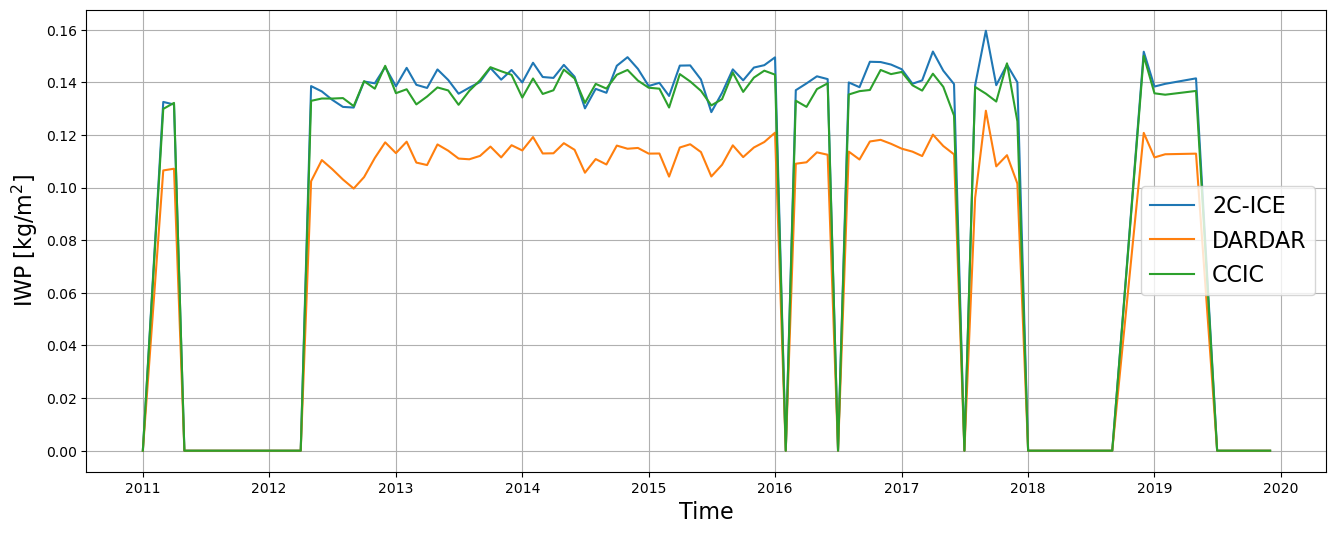

In [5]:
# plot timeseries
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(data.time.values, data.iwp_2cice.values, label='2C-ICE')
ax.plot(data.time.values, data.iwp_dardar.values, label='DARDAR')
ax.plot(data.time.values, data.iwp_ccic.values, label='CCIC')
ax.set_ylabel(r'IWP [kg/m$^2$]', fontsize=16)
ax.set_xlabel('Time', fontsize=16)
ax.grid()
ax.legend(fontsize=16)
#plt.savefig('monthly_mean.svg')

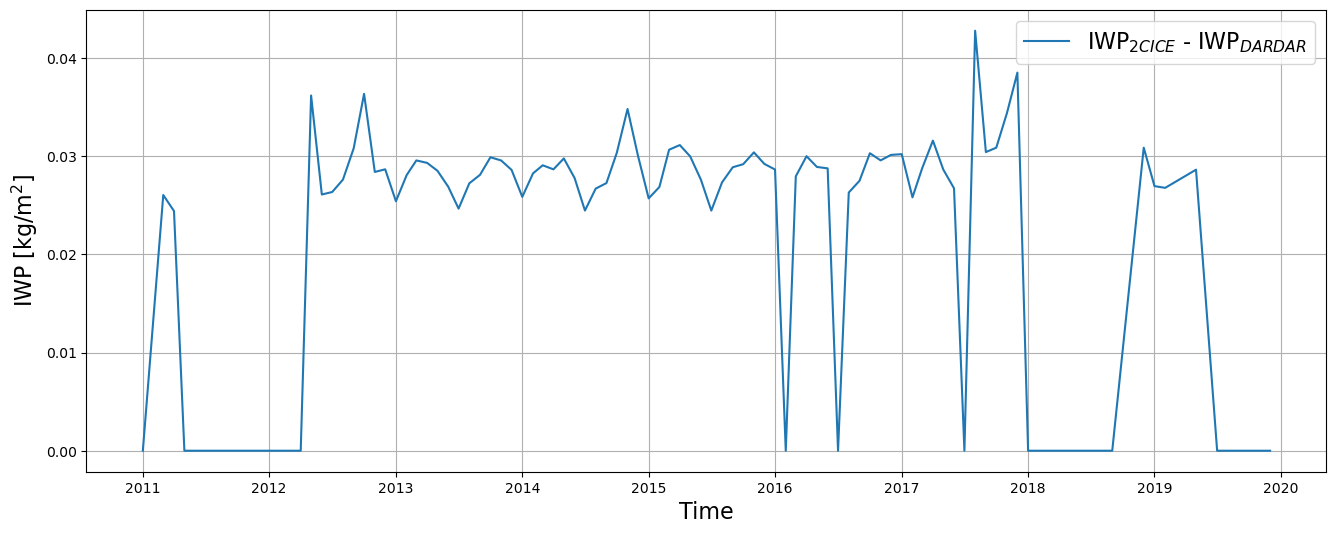

In [6]:
# plot difference between DARDAR and 2C-ICE
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(data.time.values, data.iwp_2cice.values-data.iwp_dardar.values, label=r'IWP$_{2CICE}$ - IWP$_{DARDAR}$')
ax.set_ylabel(r'IWP [kg/m$^2$]', fontsize=16)
ax.set_xlabel('Time', fontsize=16)
ax.grid()
ax.legend(fontsize=16)

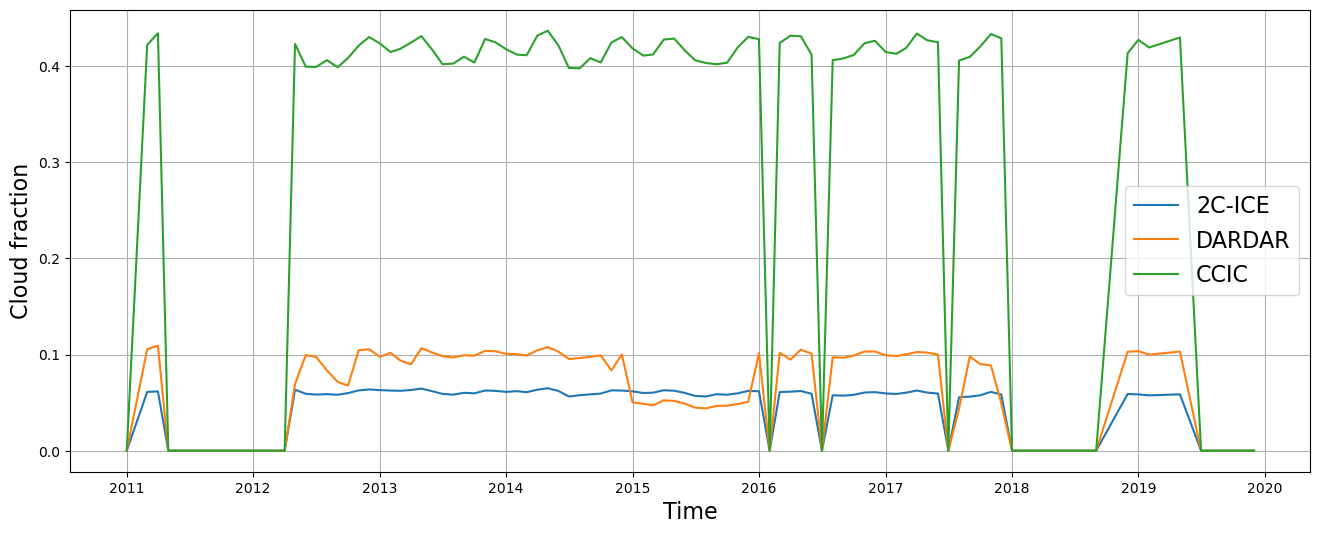

In [7]:
# plot cloudfraction timeseries
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(data.time.values, data.cloud_mask_2cice.values, label='2C-ICE')
ax.plot(data.time.values, data.cloud_mask_dardar.values, label='DARDAR')
ax.plot(data.time.values, data.cloud_mask_ccic.values, label='CCIC')
ax.set_ylabel(r'Cloud fraction', fontsize=16)
ax.set_xlabel('Time', fontsize=16)
ax.grid()
ax.legend(fontsize=16)